## Modeling Transit Time Variation (TTVs) with MCMC methods

## Add comments to this Tutorial!!

In [45]:
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
from IPython.display import display, Math
import corner
import collections
import emcee
import batman
import pythonFunctions as pfunc #Some functions come from here which is uploaded to github too
%matplotlib notebook

## Functions

In [46]:
def f_batman(x, t0, per=0.7920520, rp=0.0455, a=3.877, inc=76.39, baseline=0.0, ecc=0.0, w=90, u=[0.,0.], limb_dark ="quadratic"):
    """
    Function for computing transit models for the set of 8 free paramters
    x - time array
    """
    params = batman.TransitParams()
    params.t0 = t0                     #time of inferior conjunction
    params.per = per                  #orbital period
    params.rp =  rp         #planet radius (in units of stellar radii)
    params.a = a                      #semi-major axis (in units of stellar radii)
    params.inc = inc                     #orbital inclination (in degrees)
    params.ecc = ecc                     #eccentricity
    params.w = w                       #longitude of periastron (in degrees)
    params.u = u               #limb darkening coefficients [u1, u2]
    params.limb_dark = limb_dark       #limb darkening model

    m = batman.TransitModel(params, x)    #initializes model
    flux_m = m.light_curve(params)          #calculates light curve
    return np.array(flux_m)+baseline

#Priors
def log_prior(theta, pars):
    # Uninformative uniform prior 
    # The parameters are stored as a vector of values, so unpack them
    t0s = np.copy(theta)
    t0_probs = [] #store priors on all t0s
    for i, t0 in enumerate(t0s):
        #gaussian prior on t0s
        t0_mu = pars[i]
        t0_sigma = 1. 
        t0_prob = 1 / t0_sigma / (2 * np.pi) ** 0.5 * np.exp(-0.5 * ((t0 - t0_mu) / (t0_sigma)) ** 2)
        t0_probs.append(t0_prob)
        ##Uniform priors
        #if t0 < pars[i] - dt0 or t0 > pars[i] + dt0:
            #return -np.inf
    return np.sum(np.log(t0_probs)) 

def lc_model(theta, x):
    '''
    Model = transit1(t0_0, *pars) + transit2(t0_1, *pars) + .... 
    x: time domain
    '''
    t0 = theta[:]
    #Each transit time with same other parameters but t0 create model = LC1 + LC2 + ...
    model = np.concatenate([list(f_batman(x[i], t0[j])) for j,i in enumerate(x.keys())]) #pars contains t0 to create fake data
    
    return model

#model = LC1(t0_0, pars) + LC1(t0_1, pars) + ....
def log_likelihood(theta, x, y, yerr):
    flux, sigma2 =  np.concatenate([y[i] ** 2 for i in y.keys()]), np.concatenate([yerr[i] ** 2 for i in yerr.keys()])
    model = lc_model(theta, x)
    return -0.5 * np.sum((flux - model) ** 2 / sigma2 + np.log(2. * np.pi*sigma2))

def log_probability(theta, linear_eph, x, y, yerr):
    lp = log_prior(theta, linear_eph)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [47]:
#TESS data TOI-193
time, flux, flux_err = np.loadtxt('/home/astropc/allesfitter-master/ttvs_TOI-193/allesfit_linear_ephemerides/LTT9779b_alldata.csv', delimiter=',', skiprows=1).T

#TOI-193 modeled pars (allesfitter)
t0, per, rp, a, inc = 4915354.21679, 0.7920520, 0.0455, 3.877, 76.39
t0_err, per_err= 0.00025, 0.0000093
Tdur = 0.4681 #Infer from LC or annalytically compute it with pyfunc.transit_dur(per, rp, a, inc) 
Tdur_err = 0.0095
dt = 0.0 #add/remove dt% more of Tdur to the LC

<IPython.core.display.Javascript object>


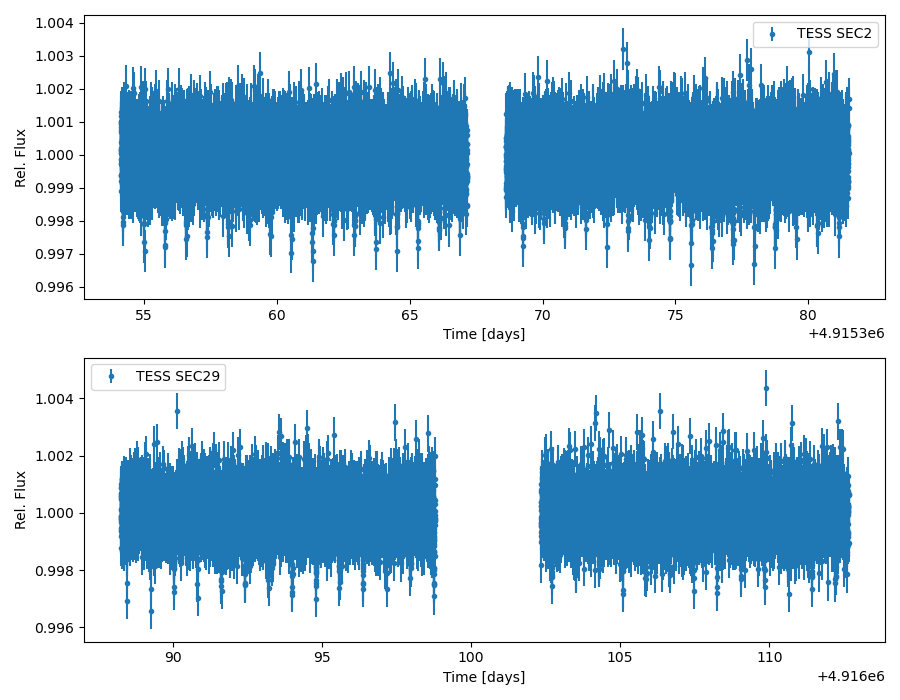

In [48]:
#plot full dataset
fig, ax = plt.subplots(2,1, figsize = (9, 7))

cond = time < (time.max() - time.min())/2 + time.min()
ax[0].errorbar(time[cond], flux[cond], flux_err[cond], fmt = '.', label = 'TESS SEC2')
ax[0].set_xlabel('Time [days]')
ax[0].set_ylabel('Rel. Flux')
ax[0].legend()

ax[1].errorbar(time[~cond], flux[~cond], flux_err[~cond], fmt = '.', label = 'TESS SEC29')
ax[1].set_xlabel('Time [days]')
ax[1].set_ylabel('Rel. Flux')
ax[1].legend()

plt.tight_layout()

In [11]:
#Only Sec2 data
time, flux, flux_err = time[~cond], flux[~cond], flux_err[~cond]

## Transits to be modeled 

<IPython.core.display.Javascript object>


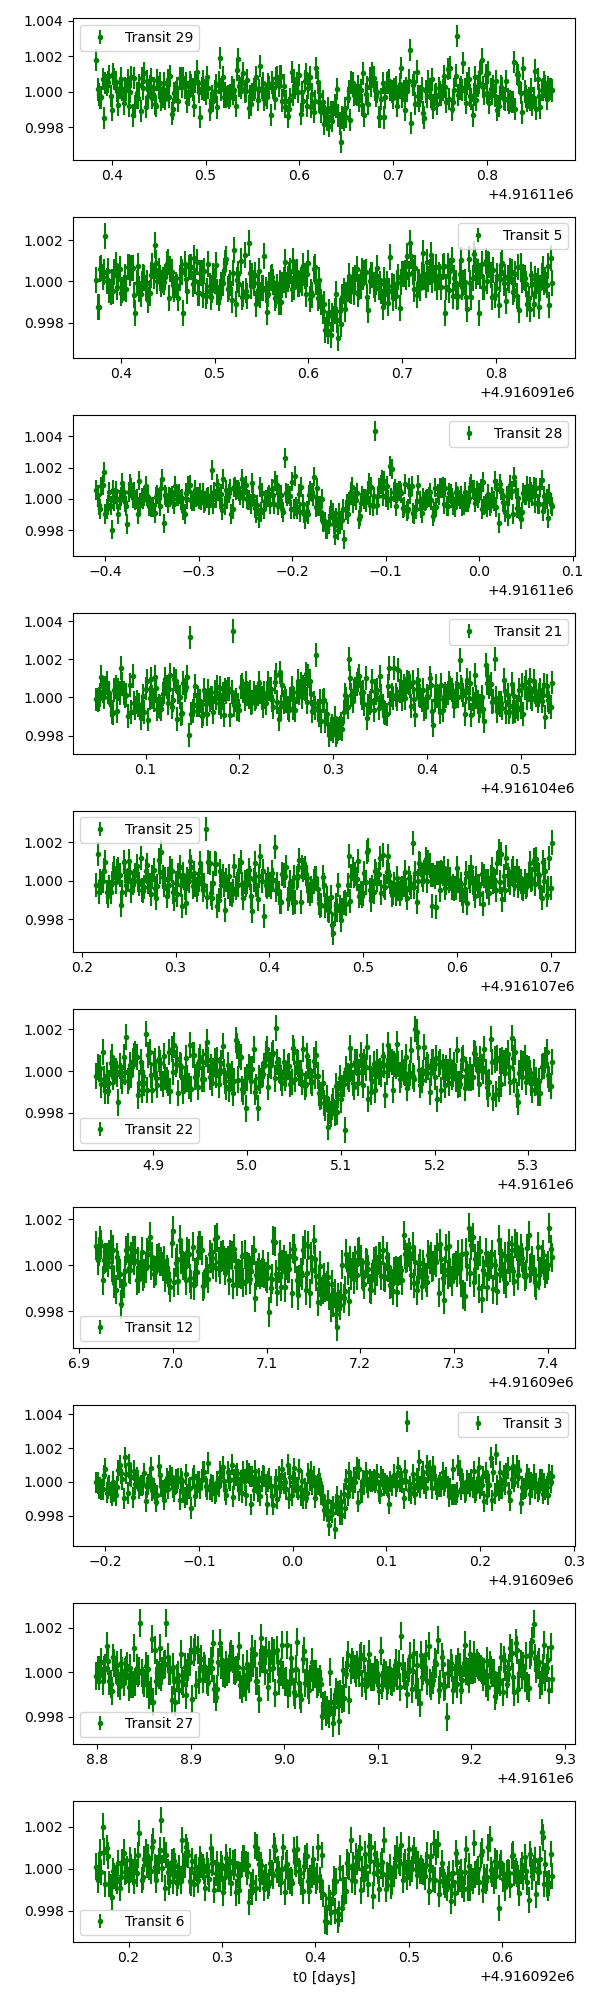

In [27]:
#Get Ingress and Egress approx. time
Ti, Te, t0 = pfunc.linear_ephemerides(t0, t0_err, per, per_err, Tdur, Tdur_err, dt, time) #errors are zero because data comes from model

#Select transit portions of LC
npoints = 300 #minimum npoints withing window Ti, Te
t_transit, f_transit, ferr_transit, N = pfunc.select_full_transits(Ti, Te, per, npoints, 10, True, time, flux, flux_err, plot=True)

#Linear ephemerides based on t0.
linear_eph = t0 + N * per

#get epochs. Epochs are the time at minimum flux from individual transits
initial_epochs_guess = np.copy(linear_eph)#np.array([t_transit[i][np.argmin(f_transit[i])] for i in t_transit.keys()])
transit_labels = [r''f't_0{i}' for i in N]

In [28]:
#MCMC settings
ndim = len(transit_labels)
nwalkers = ndim*10 # Number of walkers. It is recommended to be at least higher than twice the amount of parameters being fit
chains = 5000
order_of_mag = 1e-3#np.array([*order_of_mag_t0, 1e-3, 1e-3, 1e-3, 1e-3])
pos = initial_epochs_guess + order_of_mag * np.random.randn(nwalkers, ndim) # N(initial_pars, order_of_mag**2)

#Run MCMC with Multiple Cores
with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(linear_eph, t_transit, f_transit, ferr_transit),pool=pool)
    sampler.run_mcmc(pos, chains, progress=True)

100%|██████████| 5000/5000 [03:55<00:00, 21.27it/s]


Probably no covergence! Check tau


<IPython.core.display.Javascript object>


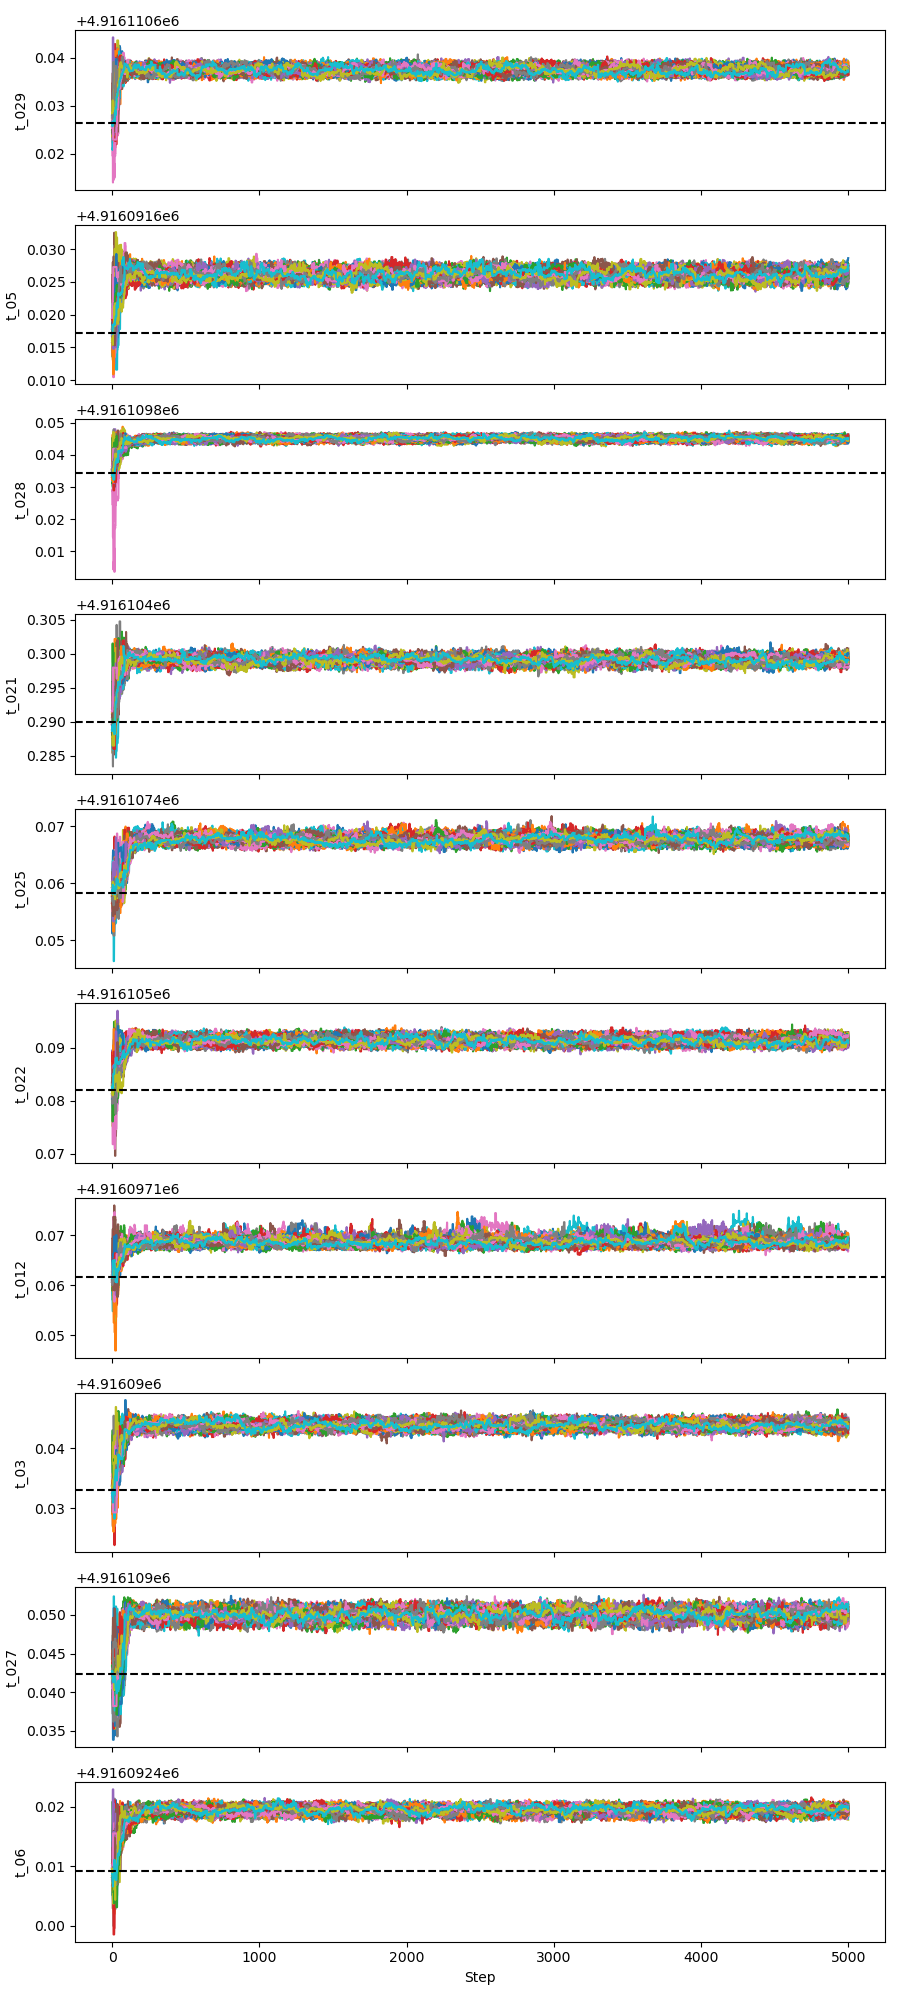

In [34]:
#Get autocorrelation time. This must be checked for all data. See trace_raw figures 
try:
    tau = sampler.get_autocorr_time()
    thinby = int(tau.max() / 2) # thin by half the max value. See emcee docs
    print(tau)
except:
    print('Probably no covergence! Check tau')
    
fig, axes = plt.subplots(ndim, sharex=True, figsize=(9.0, ndim * 2))
########################## NOTE! DRAINING RAM MEMORRY
for i in range(ndim):
    axes[i].plot(sampler.chain[:,:,i].T)
    axes[i].set_ylabel(transit_labels[i])
    axes[i].axhline(y=initial_epochs_guess[i], linestyle='--', lw=1.5, color='k')
axes[-1].set_xlabel('Step')
plt.tight_layout()

In [37]:
burn_in = int(0.3*chains)
thinby = int(0.01*chains)
flat_samples = sampler.get_chain(discard=burn_in, thin=thinby, flat=True)

fit = np.array([])

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.8f}_{{-{1:.8f}}}^{{{2:.8f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], transit_labels[i])
    display(Math(txt))
    fit = np.append(fit, [mcmc[1]])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Javascript object>


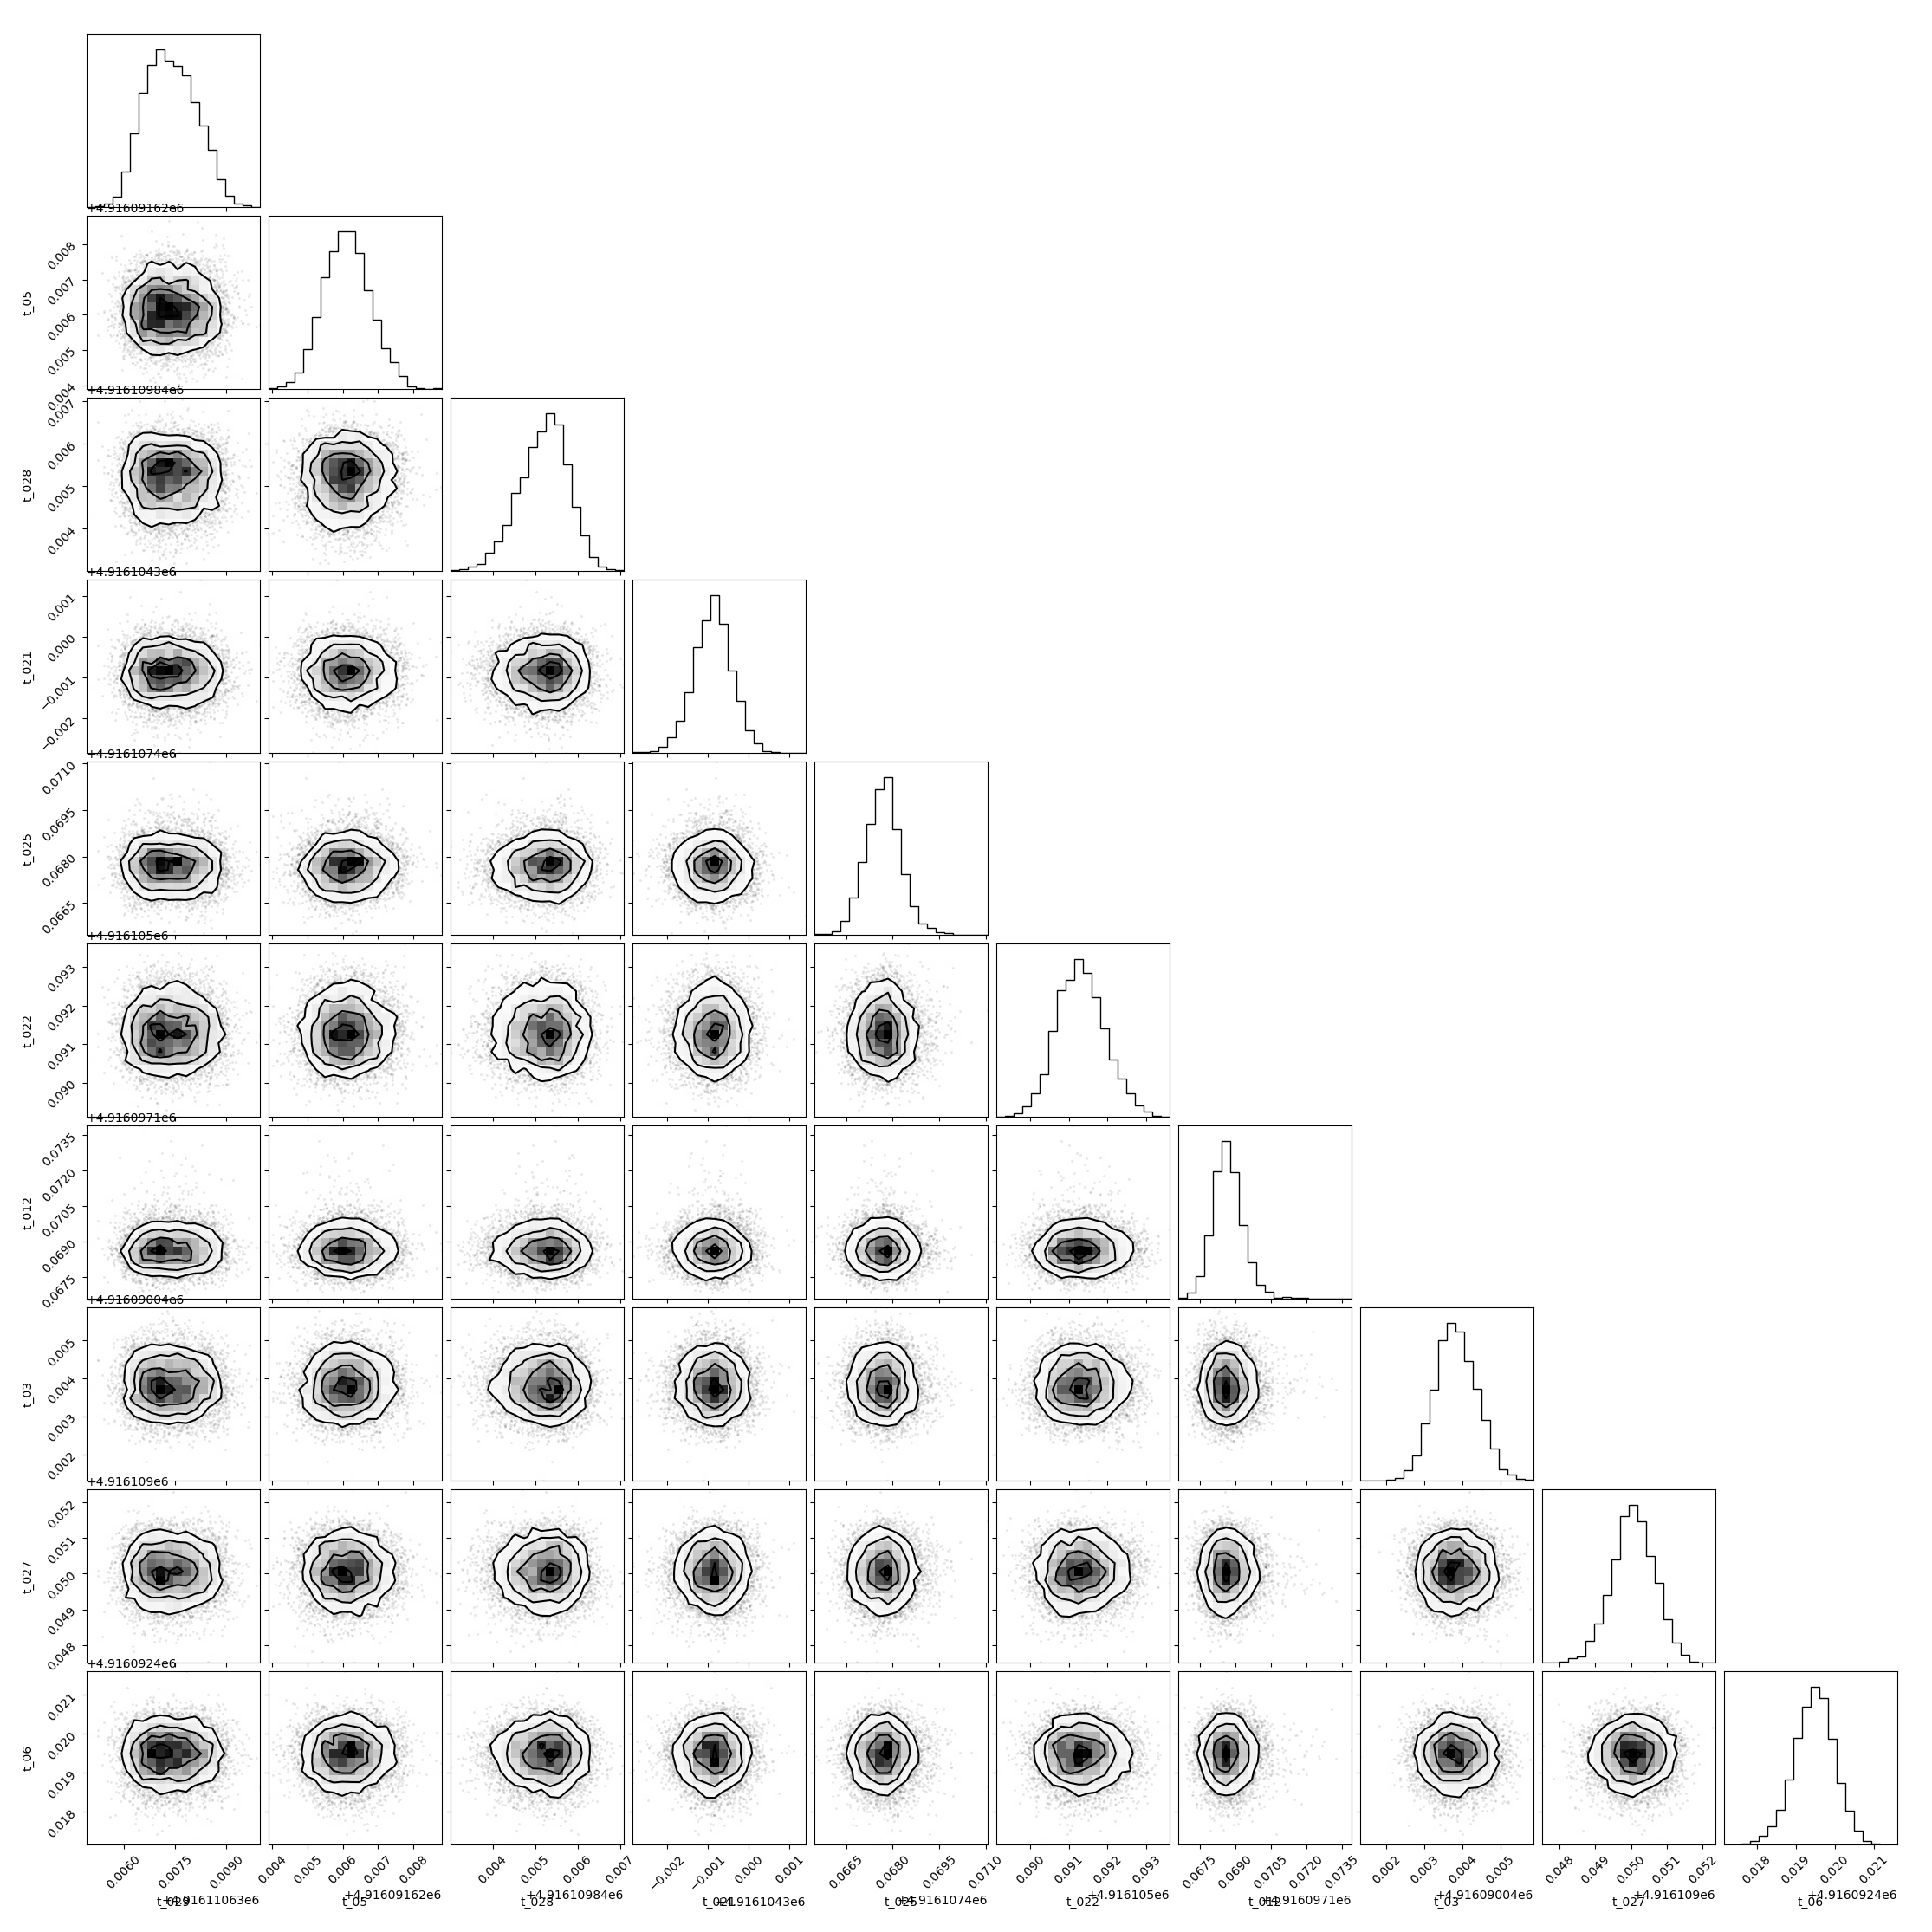

In [38]:
fig = corner.corner(flat_samples, labels=transit_labels)

<IPython.core.display.Javascript object>


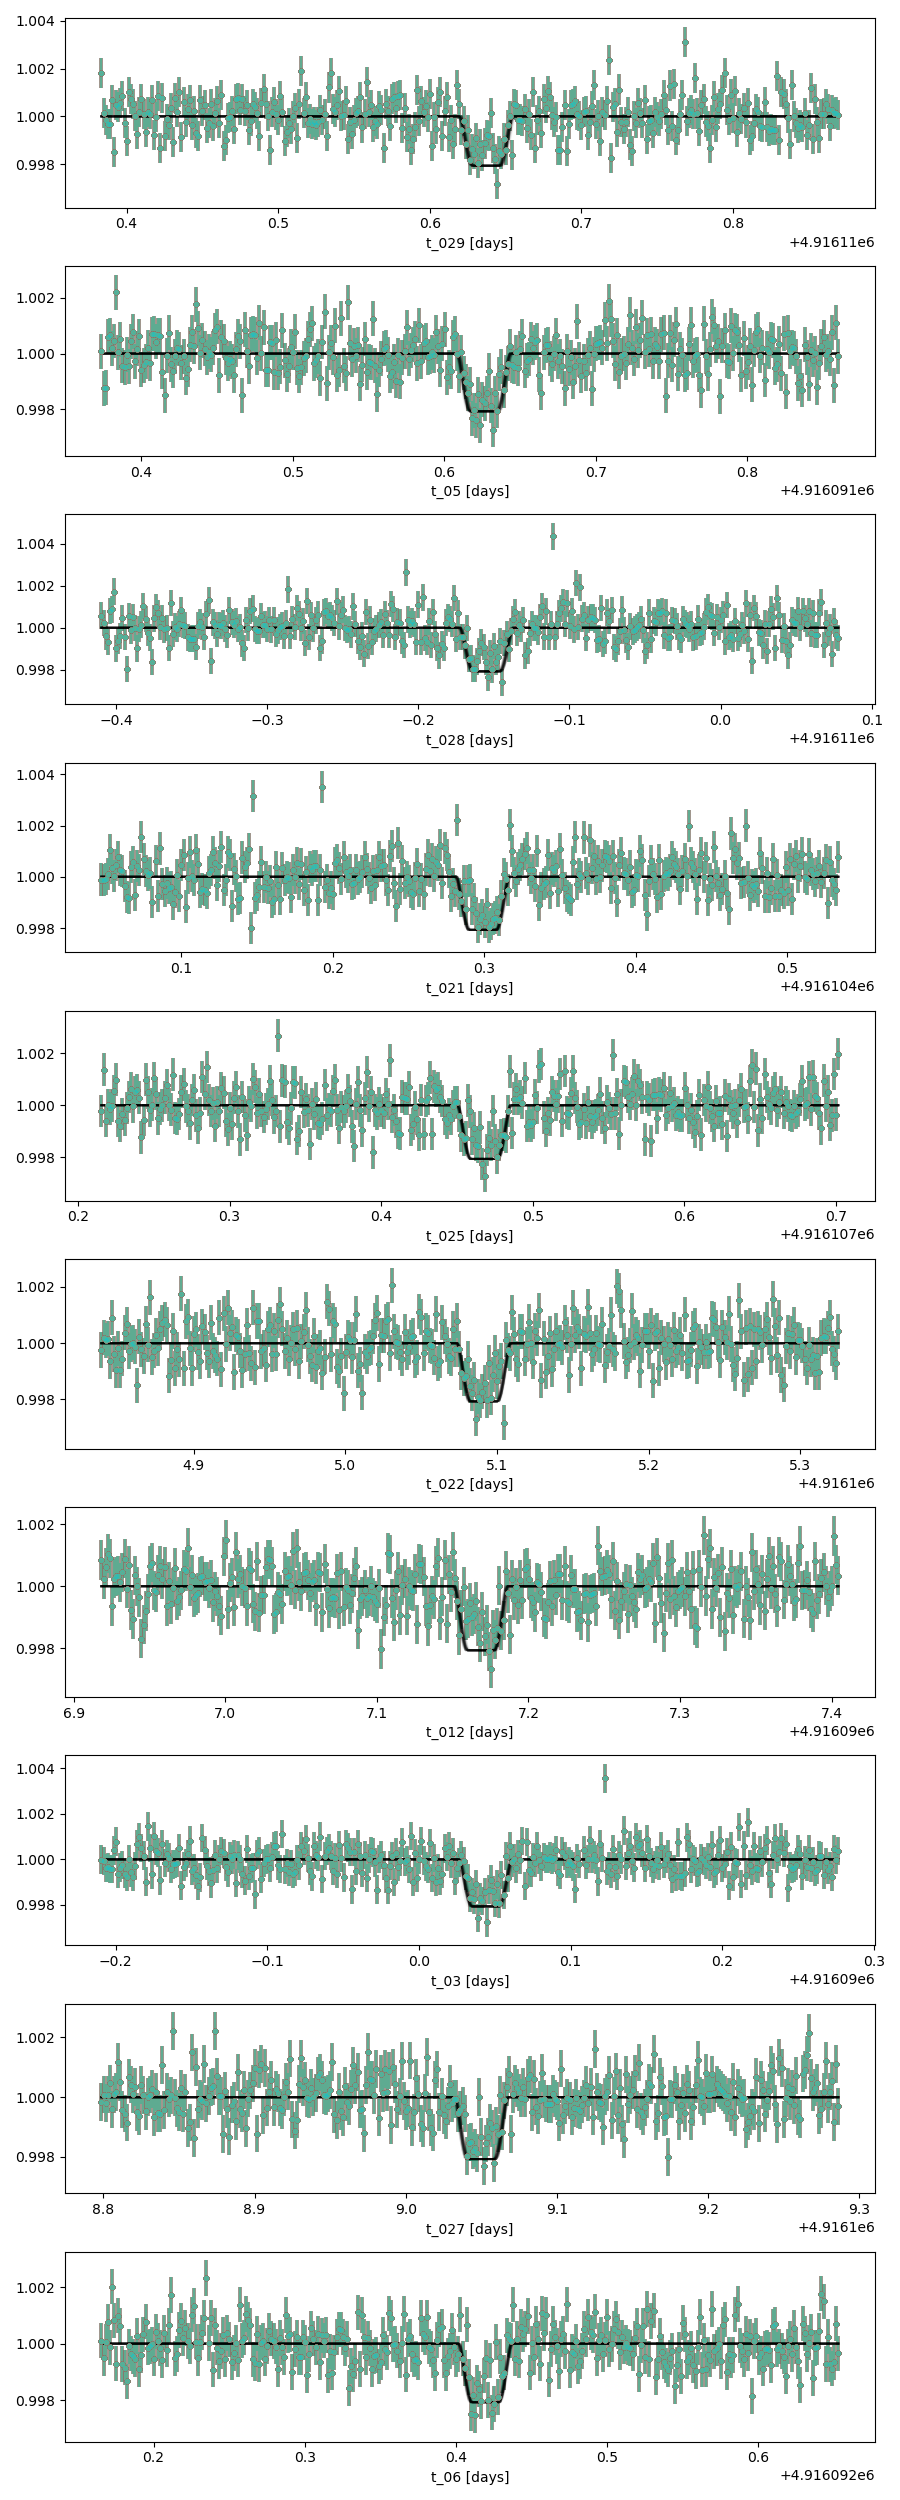

In [39]:
inds = np.random.randint(len(flat_samples), size=50)

fig, ax = plt.subplots(len(N), 1, figsize = (9, len(N)*2.5))
for i,tr in enumerate(N):    
    for ind in inds:
        ax_ = ax[i]
        sample = flat_samples[ind] #get samples parameters
        sample_flux = f_batman(t_transit[f'transit {tr}'], sample[i]) # apply pars to model
        #t, f, ferr = get_transit(Ti[tr], Te[tr], t_transit, f_transit, ferr_transit) # get individual transits
        #t_model, f_model, ferr_model = get_transit(Ti[tr], Te[tr], t_transit, sample_flux, np.zeros(t_transit.size))  #get individual trasits from model
        ax_.plot(t_transit[f'transit {tr}'], sample_flux, color='k', alpha=0.05, zorder=10)
        ax_.errorbar(t_transit[f'transit {tr}'], f_transit[f'transit {tr}'], ferr_transit[f'transit {tr}'], fmt='.', alpha=0.5, zorder=10)
        ax_.set_xlabel(transit_labels[i] + ' [days]')
plt.tight_layout()

In [40]:
#Compute TTVs from the MCMC resulting t0s - expected from linear ephemeris
ttvs = []
ttvs_err_l = []
ttvs_err_u = []
for i in range(len(fit)):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    errs = np.diff(mcmc)
    ttvs.append(mcmc[1]) 
    ttvs_err_l.append(errs[0])
    ttvs_err_u.append(errs[-1])
    
ttvs = np.array(ttvs)
ttvs_err = np.array([ttvs_err_l, ttvs_err_u])
std_ttvs = np.std(linear_eph - ttvs) * 24 * 60

<IPython.core.display.Javascript object>


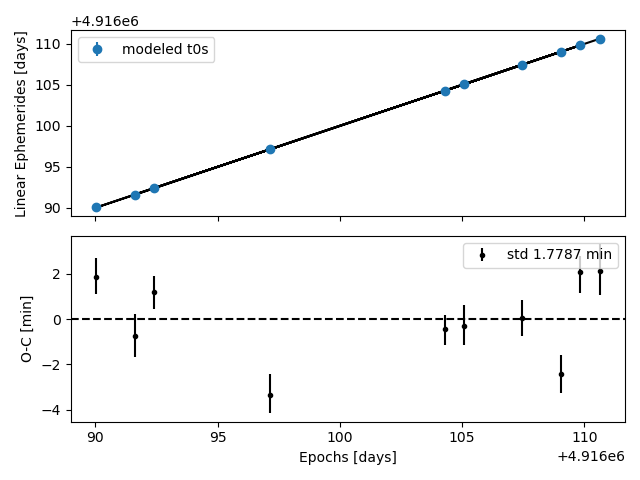

In [43]:
#plot TTVs 
fig, ax = plt.subplots(2,1, sharex=True)

#plot1
ax[0].plot(linear_eph, linear_eph, 'k')
ax[0].errorbar(linear_eph, ttvs, ttvs_err, fmt = 'o', label = "modeled t0s")
#ax[0].set_xlabel('Epochs [days]')
ax[0].set_ylabel('Linear Ephemerides [days]')
ax[0].legend()

#plot2
ax[1].errorbar(linear_eph, -1*(linear_eph - ttvs) * 24 * 60 - np.mean(-1*(linear_eph - ttvs) * 24 * 60), ttvs_err * 24 * 60, fmt = 'k.', label = f"std {std_ttvs:.4f} min")
ax[1].axhline(y=0.0, linestyle='--', lw=1.5, color='k')
ax[1].set_xlabel('Epochs [days]')
ax[1].set_ylabel('O-C [min]')
ax[1].legend()

plt.tight_layout()